# Denoising Diffusion Implicit Models

In DDPM, we construct the forward (noising) process as a Markov chain in which we add an amount of noise determined by our beta schedule at every timestep. 

Since each step in the denoising process is tied to the previous state, we are subject to a large number of denoising steps to go from xT to x0. 

In DDIM, they introduce a non-markovian forward process that leads to the same surrogate objective function as DDPM to ease this 

We can take a noise predictor pretained for DDPM and plug it into our DDIM denoising (sampling process)

In [42]:
import torch
from torch import nn

In [43]:
from src.ddpm import get_alpha_bar

## NOTE: alpha_bar from DDPM is referred to as alpha in DDIM

def denoise(
        x: torch.Tensor, 
        model_pred: torch.Tensor,
        alpha_t: torch.Tensor, 
        alpha_t_minus_1: torch.Tensor, 
        sigma_t: torch.Tensor, 
        t: int, 
        z: torch.Tensor
    ) -> torch.Tensor:
    term1 = (alpha_t_minus_1.sqrt() / alpha_t.sqrt()) * (x - (1-alpha_t).sqrt() * model_pred)
    term2 = ((1 - alpha_t_minus_1 - sigma_t.square()).sqrt()) * model_pred
    
    deterministic_term = term1 + term2
    
    if t > 0:
        x_t_minus_1 = deterministic_term + sigma_t * z
    else:
        x_t_minus_1 = deterministic_term
    
    return x_t_minus_1


def sample(
    model: nn.Module, 
    beta_schedule: torch.Tensor,
    step_size: int,
    T: int, 
    device: torch.device, 
    image_shape: tuple[int, int, int],
    num_samples: int = 16, 
    using_diffusers: bool = False
    ) -> torch.Tensor:
    """
    Sample images from the model.

    Args:
        model: the model to sample from
        beta_schedule: the beta values for each timestep
        T: the number of diffusion steps
        device: the device to sample on
        num_samples: the number of samples to generate
        image_shape: the shape of the input image
    """
    x = torch.randn(num_samples, *image_shape).to(device)
    alpha_bar = get_alpha_bar(beta_schedule)
    tau = reversed(range(0, T, step_size))

    model.eval()

    with torch.no_grad():
        for t in tau:
            time_input = torch.full((num_samples,), t, device=device)
            beta_t = beta_schedule[t]
            sigma_t = beta_t.sqrt()

            alpha_t = alpha_bar[t]
            alpha_t_minus_1 = alpha_bar[t - step_size]
            
            z = torch.randn_like(x).to(device) if t > 0 else torch.zeros_like(x).to(device)
            
            if using_diffusers:
                model_pred = model(x, time_input).sample
            else:
                model_pred = model(x, time_input)
            
            x = denoise(x, model_pred, alpha_t, alpha_t_minus_1, sigma_t, t, z)

    return x

In [46]:
from src.unet import UNet

model_checkpoint = torch.load("checkpoints/ddpm_cifar_68M_4e_4_epoch_11.pth")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

model = UNet(
    down_filters=[64, 128, 256, 512], 
    in_channels=3, 
    num_layers=2, 
    has_attention=[False, True, False, False], 
    num_heads=4, 
    diffusion_steps=1000,
    num_groups=8, 
    activation=nn.SiLU, 
    dropout=0.1
)
model.load_state_dict(model_checkpoint["model_state_dict"])
model = model.to(device)

/var/folders/27/hznbgmrn1lv4mclqkq7p2z9w8y3ynd/T/ipykernel_39891/1709087187.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_checkpoint = torch.load("checkpoints/dd

In [48]:
beta_schedule = torch.linspace(0.0001, 0.02, 1000).to(device)
sampled_images = sample(model, beta_schedule, 10, 1000, device, (3, 32, 32))
sampled_images_cpu = sampled_images.cpu()

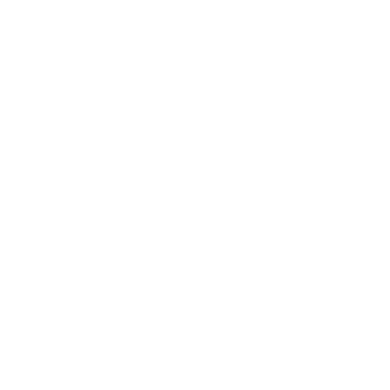

In [50]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(4, 4))

for i in range(16):
    img = sampled_images_cpu[i]
    row = i // 4
    col = i % 4
    
    img = img * 0.5 + 0.5  
    img = img.permute(1, 2, 0).numpy()
    
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.show()